# Predicting the Outcome of Bundesliga Games with Artificial Neural Nets

## Table of Contents

- [Goals of the Project](#goals-of-the-project)
- [Data and Features](#data-and-features)
    * [Training and Test Datasets](#training-and-test-datasets)
- [Models](#models)
    * [Multinomial Logistic Regression](#multinomial-logistic-regression)
    * [Deep Neural Network](#deep-neural-network)
- [Results](#results)
    * [Simulation of season 2016/17](#simulation)

## Goals of the Project <a class="anchor" id="goals-of-the-project"></a>

This project presents an attempt to quantify the predictability of the Bundesliga football games based on the information contained in game statistics starting from season 2006/07 onwards. In particular,

* we use a multinomial logistic regression and compore it to an artificial deep neural network to examine the correlations between different features provided from the statistics of individual games.
* we pose the question: "To what accuracy can one determine the outcome and score of any Bundesliga game, given the statistics of games from a number of previous seasons?"
* we compare the predictions of our model on the Bundesliga season 2016/17 up to a present matchday. We also make a prediction for the Bundesliga table for season 2016/17 according to our model.

Studying the predictive power of football statistics on the outcome of games is an interesting and challenging problem of general importance both to sports, and the development of a proper intuition about the inner workings and applicability of machine learning algorithms to sport events. The difficulty of the problem is enhanced by the occurence of physical outlier events in the data, for example a team performing better in a given game but nevertheless losing to their opponent 'misfortunately', i.e. due to 'bad luck'. Such events, although they must be accounted for by the complete realistic model, can easily be recognised as noise or bias by the classifier, e.g. a neural network, leading to an increase in both the in-sample and out-of-sample errors. 

## Data and Features <a class="anchor" id="data-and-features"></a>

We use a manually developed football games dataset, collected from data provided at [football-data.co.uk](http://football-data.co.uk/) and [kicker.de](http://kicker.de). These sets were modified introducing some new features as combinations of the existing ones, while at the same time dropping others which we considered to be less relevant.

In [68]:
# load required packages and modules
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True)

In [69]:
# load data
feats_import = pd.read_csv('All_Data_2006_2016.csv')
try:
    feats_import = feats_import.drop(['Unnamed: 0'], axis=1)
    print "Reshape successful"
except:
    print "Successful import"
    
# set a cutoff for the goal differential: all wins/losses with more than 3 goals difference are counted as wins/losses with goal differential of 3
cutoff_GD = 3
GD_min = -cutoff_GD
GD_max = +cutoff_GD
GD_spread = GD_max-GD_min + 1

# import features and drop data which are not relevant or too specific, like teams playing. 
feats = feats_import.drop(['Season', 'Gameday', u'Link', u'TID_H', u'TID_A', u'TName_H', u'TName_A', 'Odds'], axis=1).drop('FTGD', axis=1)
feats.loc[:, 'HTGD'] = feats_import.loc[:, 'HTGD'].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)) + cutoff_GD

# each data point is represented as a vector containing the following features:
print "Features:"
print feats.columns.values

Reshape successful
Features:
['HTGD' 'FTHG' 'HTHG' 'HGA' 'AGA' 'Attendance' 'ChancesA' 'ChancesH' 'HS'
 'AS' 'HST' 'AST' 'HF' 'AF' 'HC' 'AC' 'HY' 'AY' 'HR' 'AR' 'HP3' 'AP3'
 'Interval_H' 'Interval_A' 'Interval_D']


|  feature name | meaning |  feature name | meaning |  
|---|---|---|---|---|---|
|HTGD|half-time goal differential|HTHG|half-time home goals|
|FTHG|full-time home goals|Attendance|Attendance in stadium, normalized to home team's maximum of that season|
|HGA|home team grade avgerage|AGA|away team grade avgerage|
|ChancesH|home team scoring opportunities|ChancesA|away team scoring opportunities|
|HS|home team shots|AS|away team shots|
|HST|home team shots on target|AST|away team shots on target|
|HF|home team fouls committed|AF|away team fouls committed|
|HC|home team corner kicks|AC|away teams corner kicks|
|HY|home teams yellow cards|AY|away teams yellow cards|
|HR|home team red cards|AR|away team red cards|
|HP3|home team points in last 3 games|AP3|away team points in last 3 games|
|Interval_W|fraction of 90 minutes winning team was in the lead</span>|Interval_L|fraction of 90 minutes losing team was in the lead|
|Interval_D|fraction of 90 minutes match was in a tie||||


To acquire a better understanding of the data used to train the deep neural net, below we show histrograms of selected interesting features, that are often used by the experts to intuitively estimate and argue for the outcome of a particular fixture:

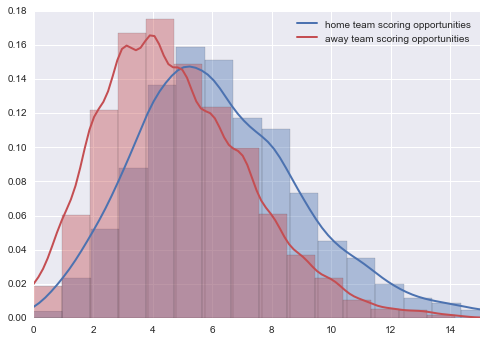

In [70]:
dp = sns.distplot(feats_import.loc[:, 'ChancesH'],
                  bins=np.int(feats_import.loc[:, 'ChancesH'].max()-feats_import.loc[:, 'ChancesH'].min()+1), axlabel=False,
                  kde_kws={'label':'home team scoring opportunities',"linewidth": 2,"color": "b"},
                  hist_kws={"color": "b"})
dp.set(xlim=(0, 15))

dp = sns.distplot(feats_import.loc[:, 'ChancesA'],
                  bins=np.int(feats_import.loc[:, 'ChancesA'].max()-feats_import.loc[:, 'ChancesA'].min()+1), axlabel=False,
                  kde_kws={'label':'away team scoring opportunities',"linewidth": 2,"color": "r"},
                  hist_kws={"color": "r"})

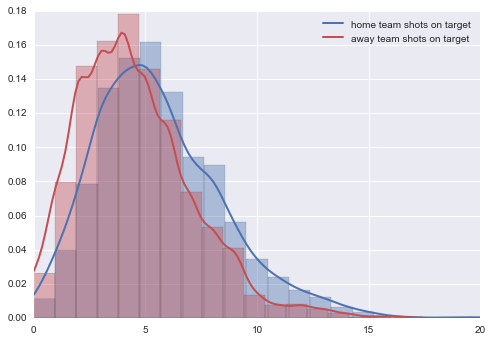

In [71]:
dp = sns.distplot(feats_import.loc[:, 'HST'],
                  bins=np.int(feats_import.loc[:, 'HST'].max()-feats_import.loc[:, 'HST'].min()+1), axlabel=False,
                  kde_kws={'label':'home team shots on target',"linewidth": 2,"color": "b"},
                  hist_kws={"color": "b"})
dp.set(xlim=(0, 20))

dp = sns.distplot(feats_import.loc[:, 'AST'],
                  bins=np.int(feats_import.loc[:, 'AST'].max()-feats_import.loc[:, 'AST'].min()+1), axlabel=False,
                  kde_kws={'label':'away team shots on target',"linewidth": 2,"color": "r"},
                  hist_kws={"color": "r"})

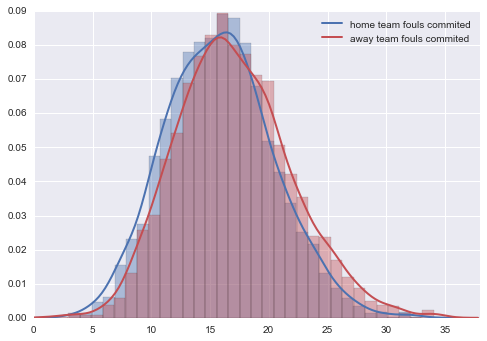

In [72]:
dp = sns.distplot(feats_import.loc[:, 'HF'],
                  bins=np.int(feats_import.loc[:, 'HF'].max()-feats_import.loc[:, 'HF'].min()+1), axlabel=False,
                  kde_kws={'label':'home team fouls commited',"linewidth": 2,"color": "b"},
                  hist_kws={"color": "b"})
dp.set(xlim=(0, 38))

dp = sns.distplot(feats_import.loc[:, 'AF'],
                  bins=np.int(feats_import.loc[:, 'AF'].max()-feats_import.loc[:, 'AF'].min()+1), axlabel=False,
                  kde_kws={'label':'away team fouls commited',"linewidth": 2,"color": "r"},
                  hist_kws={"color": "r"})

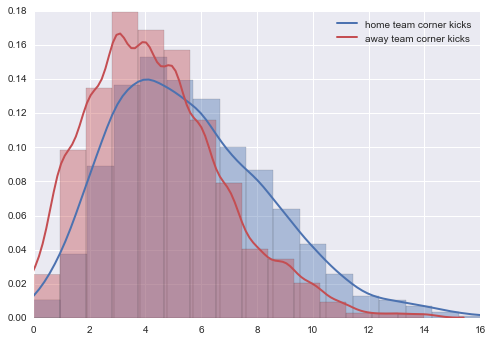

In [73]:
dp = sns.distplot(feats_import.loc[:, 'HC'],
                  bins=np.int(feats_import.loc[:, 'HC'].max()-feats_import.loc[:, 'HC'].min()+1), axlabel=False,
                  kde_kws={'label':'home team corner kicks',"linewidth": 2,"color": "b"},
                  hist_kws={"color": "b"})
dp.set(xlim=(0, 16))

dp = sns.distplot(feats_import.loc[:, 'AC'],
                  bins=np.int(feats_import.loc[:, 'AC'].max()-feats_import.loc[:, 'AC'].min()+1), axlabel=False,
                  kde_kws={'label':'away team corner kicks',"linewidth": 2,"color": "r"},
                  hist_kws={"color": "r"})

### Training and Test Datasets <a class="anchor" id="training-and-test-datasets"></a>

Using the data points discussed above, we now put together a training and a test data set as follows: 

In [74]:
# Overview over the data set
feats_import.head()

,Season,Gameday,Link,TID_H,TID_A,TName_H,TName_A,FTGD,HTGD,FTHG,...,AC,HY,AY,HR,AR,HP3,AP3,Interval_H,Interval_A,Interval_D
0,2006,1,2,0,12,Bayern Munich,Dortmund,2.0,1.0,2.0,...,4.0,1.0,2.0,0.0,0.0,0.5,0.5,0.733333,0.000000,0.266667
1,2006,1,1,1,16,Hamburg,Bielefeld,0.0,-1.0,1.0,...,2.0,3.0,2.0,0.0,0.0,0.5,0.5,0.000000,0.388889,0.611111
2,2006,1,8,2,10,Leverkusen,Aachen,3.0,2.0,3.0,...,1.0,3.0,0.0,1.0,1.0,0.5,0.5,0.644444,0.000000,0.355556
3,2006,1,6,3,17,Mainz,Bochum,1.0,1.0,2.0,...,8.0,2.0,3.0,0.0,0.0,0.5,0.5,0.677778,0.000000,0.322222
4,2006,1,3,4,11,M'gladbach,Cottbus,2.0,0.0,2.0,...,5.0,0.0,4.0,0.0,1.0,0.5,0.5,0.433333,0.000000,0.566667


We normalise each feature from the data to unity with respect to all games in the data set, unless otherwise stated.

In [75]:
# Normalize the data set to values between 0 and 1
norm = [GD_spread-1, 9, 5, 1, 1, 1, 22, 22, 36, 36, 36, 33, 35, 35, 20, 20, 11, 11, 4, 4, 1, 1, 1, 1, 1]
feats = feats/norm

# Identify the point where season 2015/16 ends and thus the most recent season begins
season15_end = feats_import[feats_import['Season']==2016].index[0]

# Create the labels for the goal differentials between -cutoff_GD and +cutoff_GD
label = feats_import.loc[:, 'FTGD'].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)) + cutoff_GD


# Bring X and y into numpy format
X_train = feats.iloc[:season15_end].as_matrix()
y_bare = map(int, label.iloc[:season15_end].as_matrix())

# input and output dimensions
input_dim=X_train.shape[1]
output_dim = len(set(y_bare)) # = 2*cutoff_GD+1
nb_classes = len(set(y_bare))

# categorical classification values
Y_train = np_utils.to_categorical(y_bare, nb_classes)

The test data set is defined as the data avaiable up to the present matchday of the current season:

In [76]:
# Data from the most recent season
X_test = feats.iloc[season15_end+1:].as_matrix()
y_test_bare = map(int, label.iloc[season15_end+1:].as_matrix())

# input and output dimensions
input_dim_test=X_test.shape[1]

# categorical classification values
Y_test = np_utils.to_categorical(y_test_bare, nb_classes)

## Models <a class="anchor" id="models"></a>

To gain an intuition about how eep neural networks work, we start off with the simpler model of a multinomial logistic regression, before we introduce multiple hidden layers.

### Multinomial Logistic Regression  <a class="anchor" id="multinomial-logistic-regression"></a>

A multinomial logistic regression is a soft-max model which outputs the probabilities for a given feature vector to fall in one out of multiple classification categories. The error function of the logistic refression is the cross entropy, and it is typically minimised numerically, e.g. using Stochastic Gradient Descnet or the ADAM optimisers. 

We start by defining the batch size used by ADAM, and the corresponding number of training epochs (a.k.a. the iterations in minimising the cross entropy).

In [77]:
nb_epoch=100
batch_size=10

Let us set up the log-reg model using Keras, and check how well it fits the train data

In [78]:
# build log-reg model (softmax)
log_reg_model = Sequential() 
log_reg_model.add(Dense(output_dim, input_dim=input_dim, activation='softmax')) 
log_reg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

# fit the train data to check how well it recognises it
log_reg_model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,verbose=0) 
score_train = log_reg_model.evaluate(X_train, Y_train, verbose=0) 
print('Training score:', score_train[0]) 
print('Training accuracy:', score_train[1])

('Training score:', 1.0275665792764401)
('Training accuracy:', 0.55163398700601918)


### Deep Neural Network <a class="anchor" id="deep-neural-network"></a>

Our second and major model is a more sophisticated deep relu neural net with the following architecture (consider putting table horizontally?):

|layer|input | hidden 1| hidden 2| hidden 3| hidden 4|softmax output|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|*number of relu neurons*|25|50|500|500|50|7| 

We train with minibatches using the ```adam``` optimiser, and minimise the categorical entropy function. Additionally, we apply ```dropout``` regularisation before hidden layer 2 and after hidden layer 4.
 




In [79]:
### set up the deep neural net with Keras
dropout_p = 0.3
# initiate model
model = Sequential()
# add weights input_layer--hidden_layer 1
model.add(Dense(50, input_dim=input_dim, init='lecun_uniform', activation='relu')) 
# dropout layer 1
model.add(Dropout(dropout_p))
# add hidden layer 2
model.add(Dense(500, activation='relu'))
# add hidden layer 3
model.add(Dense(500, activation='relu'))
# add hidden layer 4
model.add(Dense(50, activation='relu'))
# dropout layer 2
model.add(Dropout(dropout_p))
# output layer
model.add(Dense(output_dim, activation='relu'))
model.add(Activation('softmax'))
### compile model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

As before, we train the model on the training data with $100$ epochs and a mini-batch size of $10$. <br>
Since we use a softmax activation, the neural network outputs probabilities for the different outcomes of goal differentials.

In [80]:
model.fit(X_train, Y_train, nb_epoch=nb_epoch, batch_size=batch_size, verbose=False)
print model.evaluate(X_train, Y_train, batch_size=batch_size, verbose=False)[1]

predictions = model.predict_proba(X_train)

0.674836604278
3060/3060 [==============================] - 0s     


The ```model.evaluate()``` function tests the accuracy to which the network has learned to recognize the results of a match just by the stats of given game. <br> 
We achieve $\approx 70\%$ accuracy. This result can be improved considerably by considering a smaller cutoff goal differential. In the extreme case of a goal differential cutoff of $1$, the artificial neural network only tries to learn the winner and loser or if there was a draw.

We use the softmax outcome probabilities to calculate the expected score via the function ```exp_score()```:

In [81]:
# assign an expected score with probabilities
def exp_score(x):
    multiplier = np.array(range(-cutoff_GD, cutoff_GD+1))
    return np.sum(np.array(x) * multiplier)

# cross-tabulation for away-win (-1), draw (0) or home-win (1)
performance_df = pd.concat([
        label.iloc[:season15_end] + GD_min,
        pd.Series(data=map(np.round, map(exp_score, predictions)), name='EXP', index=label.iloc[:season15_end].index)], axis=1)

success_res_df = pd.crosstab(performance_df.loc[:, "FTGD"].apply(np.sign), performance_df.loc[:, "EXP"].apply(np.sign))
print "Success identifying H, D, A is " + str(round(100. * np.trace(success_res_df)/season15_end,2)) + " percent"
success_res_df

Success identifying H, D, A is 91.44 percent


EXP,-1.0,0.0,1.0
FTGD,,,
-1.0,851,69,2
0.0,36,631,87
1.0,0,68,1316


As we can see, the expected result for ```win```, ```draw```, ```loss``` correctly classifies the outcome of the game in $\approx 92\%$ of the data set.

In [82]:
# cross-tabulation for exact goal differential

success_df = pd.crosstab(performance_df.loc[:, "FTGD"], performance_df.loc[:, "EXP"])#, margins=True)
exp_min = int(performance_df.loc[:, "EXP"].min())
exp_max = int(performance_df.loc[:, "EXP"].max())
print "Success identifying GD is " + str(round(np.sum([100.*success_df.ix[i,i] for i in range(exp_min,exp_max+1)])/season15_end,2)) + " percent"
success_df

Success identifying GD is 66.31 percent


EXP,-3.0,-2.0,-1.0,-0.0,1.0,2.0,3.0
FTGD,,,,,,,
-3.0,77,86,15,0,0,0,0
-2.0,2,159,111,4,0,0,0
-1.0,0,88,313,65,2,0,0
0.0,0,0,36,631,87,0,0
1.0,0,0,0,68,532,12,0
2.0,0,0,0,0,241,170,4
3.0,0,0,0,0,6,204,147


On the other hand, the expected result with respect to the goal differential correctly classifies the outcome of the game in $\approx 69\%$ of the data set. 
Since the most important consequence of goal differential is the decision about win, draw, and loss, we consider mis-classification as long as the outcome of the game is correct, not important. 

Many of the games can be clearly characterized in their outcome from the game statistics, which the decent result for logistic regression showed. 
Some games, however, lack predictive power and their outcome is not representative of a typical game with this game statistics. 
Since the goal of the project is to classify the games in the current season by the expected outcome, had they ended like a ''typical'' game, we train our neural net a second time. 
We use the following assumption: games for which our algorithm does not classify ```win```, ```draw```, and ```loss``` correctly are decided by ```luck.``` Therefore we exclude all games which have been misclassified in this manner, and we make the algorithm fit outcomes again. We call this second model, ```model_noluck``` and compare it to the previus one.


In [83]:
# 3 points for winning team, 1 point each for draw, 0 points for losing team
def points(x):
    if x > 0:
        return 3
    elif x == 0:
        return 1
    else:
        return 0

# Points assigned to teams according to actual and expected score (algorithm)
performance_df.loc[:, "FP"] = performance_df.loc[:, "FTGD"].apply(points)
performance_df.loc[:, "EP"] = performance_df.loc[:, "EXP"].apply(points)

# Indicators if points and goal differential are different 
performance_df.loc[:, "GD_err"] = (performance_df.loc[:, "FTGD"] - performance_df.loc[:, "EXP"]).apply(np.abs)
performance_df.loc[:, "P_err"] = (performance_df.loc[:, "FP"]-performance_df.loc[:, "EP"]).apply(np.sign).apply(np.abs)

# All games which have been misclassified in outcome and only by one goal
performance_df = performance_df.merge(
    performance_df.query('(GD_err == 1) & (P_err == 1)').loc[:, "P_err"].to_frame().rename(columns={"P_err":"Luck"}),
    left_index=True, right_index=True, how='left').fillna(0)

In [84]:
# Create data frame with only correctly predicted games and then learn on them
feats_noluck = feats.merge(performance_df.loc[:, "Luck"].to_frame(), 
                           left_index=True, right_index=True, 
                           how='inner').query('Luck != 1').drop('Luck', axis=1)

label = feats_import.loc[:, 'FTGD'].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)) + cutoff_GD

GD_min = -cutoff_GD
GD_max = +cutoff_GD
GD_spread = GD_max-GD_min + 1


label_noluck = label.to_frame().merge(feats_noluck, left_index=True, right_index=True).loc[:, 'FTGD']


X_noluck = feats_noluck.ix[:season15_end].as_matrix()
y_bare_noluck = map(int, label_noluck.ix[:season15_end].as_matrix())

# input and output dimensions
input_dim_noluck=X_noluck.shape[1]

# categorical classification values
Y_noluck = np_utils.to_categorical(y_bare_noluck, nb_classes)

In [85]:
### set up the deep neural net with Keras
dropout_p = 0.4
# initiate model
model_noluck = Sequential()
# add weights input_layer--hidden_layer 1
model_noluck.add(Dense(50, input_dim=input_dim_noluck, init='lecun_uniform', activation='relu')) 
# dropout layer 1
model_noluck.add(Dropout(dropout_p))
# add hidden layer 2
model_noluck.add(Dense(500, activation='relu'))
# add hidden layer 3
model_noluck.add(Dense(500, activation='relu'))
# add hidden layer 4
model_noluck.add(Dense(50, activation='relu'))
# dropout layer 2
model_noluck.add(Dropout(dropout_p))
# output layer
model_noluck.add(Dense(output_dim, activation='relu'))
model_noluck.add(Activation('softmax'))
### compile model
model_noluck.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


model_noluck.fit(X_noluck, Y_noluck, nb_epoch=nb_epoch, batch_size=batch_size, verbose=False)
print model_noluck.evaluate(X_noluck, Y_noluck, batch_size=batch_size, verbose=False)[1]

predictions_noluck = model_noluck.predict_proba(X_noluck)

0.624108421192
2720/2804 [============================>.] - ETA: 0s

In [86]:
performance_noluck_df = pd.concat([
        (label_noluck.ix[:season15_end]-cutoff_GD).apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)),
        pd.Series(data=map(np.round, map(exp_score, predictions_noluck)), name='EXP', index=label_noluck.ix[:season15_end].index)], axis=1)
success_noluck_res_df = pd.crosstab(performance_noluck_df.loc[:, "FTGD"].apply(np.sign), performance_noluck_df.loc[:, "EXP"].apply(np.sign))
print "Success identifying H, D, A is " + str(round(100. * np.trace(success_noluck_res_df)/len(label_noluck.ix[:season15_end]),2)) + " percent"
success_noluck_res_df

Success identifying H, D, A is 93.97 percent


EXP,-1.0,0.0,1.0
FTGD,,,
-1.0,765,92,0
0.0,2,623,6
1.0,0,69,1247


Obviously, now the algorithm will work much more precisely, by construction. 

## Results <a class="anchor" id="results"></a>

To check how much the neural network has learned and what the degree of overfittig is, it is necessary to test the model on new, previously unseen data -- the test data. 

As before, we begin by evaluating the multinomial logistic regression on the test data. We apply the log-reg model to predict outcomes of games played in the most recent season, our test data. We feed the features of the games and use the softmax output to calculate the expected goal differential.

In [87]:
log_reg_model.fit(X_test, Y_test, batch_size=batch_size, nb_epoch=nb_epoch,verbose=0) 
score_test = log_reg_model.evaluate(X_test, Y_test, verbose=0)

print('Test score:', score_test[0]) 
print('Test accuracy:', score_test[1])

performance_new_season_log_reg_df = pd.concat([
        feats_import.iloc[season15_end+1:,7].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)),
        pd.Series(data=map(np.round, map(exp_score, log_reg_model.predict_proba(X_test))), name='EXP', index=feats_import.iloc[season15_end+1:].index)], axis=1)
success_new_season_log_reg_res_df = pd.crosstab(performance_new_season_log_reg_df.loc[:, "FTGD"].apply(np.sign), performance_new_season_log_reg_df.loc[:, "EXP"].apply(np.sign))
print "\n"
print "Success identifying H, D, A is " + str(round(100.* np.trace(success_new_season_noluck_res_df)/len(X_test),2)) + " percent"
success_new_season_log_reg_res_df

('Test score:', 0.98156189960199636)
('Test accuracy:', 0.59440559690648864)
 32/143 [=====>........................] - ETA: 0s

Success identifying H, D, A is 85.31 percent


EXP,-1.0,0.0,1.0
FTGD,,,
-1.0,28,9,1
0.0,3,27,7
1.0,0,6,62


Let us now check by how much these percentages improve, if we use the more sophisticated deep neural network:

In [88]:
predictions_new_season_noluck = model_noluck.predict_proba(X_test)
print '\n'


performance_new_season_noluck_df = pd.concat([
        feats_import.iloc[season15_end+1:,7].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)),
        pd.Series(data=map(np.round, map(exp_score, predictions_new_season_noluck)), name='EXP', index=feats_import.iloc[season15_end+1:].index)], axis=1)
success_new_season_noluck_res_df = pd.crosstab(performance_new_season_noluck_df.loc[:, "FTGD"].apply(np.sign), performance_new_season_noluck_df.loc[:, "EXP"].apply(np.sign))
print "Success identifying H, D, A is " + str(round(100.* np.trace(success_new_season_noluck_res_df)/len(X_test),2)) + " percent"
success_new_season_noluck_res_df

128/143 [=========================>....] - ETA: 0s

Success identifying H, D, A is 86.01 percent


EXP,-1.0,0.0,1.0
FTGD,,,
-1.0,28,9,1
0.0,0,31,6
1.0,0,4,64


While the neural network, dropping all ```lucky``` games, could correctly classify the outcome of more than $\approx 98\%$ of the games on the training set, the rate drops to $\approx 86\%$ percent on the test set. We assume that this is mostly due to games that have ended differently than expected. 

### Simulation of season 2016/17 <a class="anchor" id="simulation"></a>

Let us now use our model to make a prediction on the ourcome of season 2016/17 using our models. Notice that this problem differs than the one above, in that we do not want to classify the outcomes by the goal differential, but rather find out the points each team should have, had the games been played according to our model. In other words, did the games end as an average game with similar game statistics did in the past.

In [89]:
# Define functions

# Instead of finding the expected goal differential, we can find the expected points. 
def exp_score_cont(x):
    multiplier = np.array([0, 0, 0, 1, 3, 3, 3])
    return np.sum(np.array(x) * multiplier)

# We have a cut-off at a goal differential of plus-minus 3. However, on average, plus-minus 3.6 goals are the GD
# in games where the winning team scores at least 3 goals more.
def exp_score_corr(x):
    multiplier = np.array([-3.0, -2, -1, 0, 1, 2, 3.0])
    return np.sum(np.array(x) * multiplier)

In [90]:
# Write new DataFrame to store the games and the expected outcome including points.
simulated_season = pd.DataFrame(data=None, columns=['Gameday', 'TID_H', 'TID_A', 'GD', 'EP_H', 'EP_A'])

for gd in range(1, 17): # loop over gamedays
    # new_feats_import is raw data for season 2016
    new_feats_import_df = feats_import.loc[(feats_import['Season']==2016) & (feats_import['Gameday']==gd)]

    # Copy the feats from the actual data
    new_feats_df = new_feats_import_df.drop(['Season', 'Gameday', u'Link', u'TName_H', u'TName_A', 'Odds'], axis=1).drop('FTGD', axis=1)
    new_feats_df.loc[:, 'HTGD'] = new_feats_df.loc[:, 'HTGD'].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)) + cutoff_GD

    # On Gameday 1, we use 0.5 for the last points.
    # For later gamedays, we use the actual results from the simulated season.
    if gd > 1:
        new_feats_df.ix[:, "HP3"] = last_game.ix[:, "P_H"].tolist()
        new_feats_df.ix[:, "AP3"] = last_game.ix[:, "P_A"].tolist()

    
    # Vectors to feed to neural network
    X_test_gameday = new_feats_df.drop([u'TID_H', u'TID_A'], axis=1).as_matrix() / norm
    y_bare_test_gameday = map(int, label.iloc[season15_end+(gd-1)*9:season15_end+(gd*9)].as_matrix())
    
    Y_test_gameday = np_utils.to_categorical(y_bare_test_gameday, nb_classes)
    

    # Score games
    predictions_new_gameday = model.predict_proba(X_test_gameday)

    # Write data
    data = np.array([np.array([gd for _ in range(9)]),
    new_feats_import_df.loc[:, 'TID_H'].tolist(),
    new_feats_import_df.loc[:, 'TID_A'].tolist(),
    map(exp_score_corr, predictions_new_gameday),
    map(exp_score_cont, predictions_new_gameday),
    map(exp_score_cont, np.fliplr(predictions_new_gameday))]).T

    # simulated_df is a running DataFrame containing all matches of the season.
    simulated_df = pd.DataFrame(data=data, columns=['Gameday', 'TID_H', 'TID_A', 'GD', 'EP_H', 'EP_A'])
    simulated_df = pd.merge(simulated_df, new_feats_import_df.loc[:, ["Gameday", "TID_H", "FTGD"]], left_on=["Gameday", "TID_H"], right_on=["Gameday", "TID_H"])

    simulated_season = simulated_season.append(simulated_df, ignore_index=True)

    # Assign points according to rounded expected goal differential
    simulated_df.loc[:, "P_H"] = simulated_df.loc[:, "GD"].apply(np.round).apply(points)
    simulated_df.loc[:, "P_A"] = (-simulated_df.loc[:, "GD"]).apply(np.round).apply(points)

    if gd == 1:
        simulated_df.loc[:, ['TID_H', 'P_H']].set_index('TID_H').rename(columns={'P_H':'P' + str(gd)})
        # Write standings into a DataFrame for Gameday 1
        standings = pd.DataFrame(pd.concat([1./3 * simulated_df.loc[:, ['TID_H', 'P_H']].set_index('TID_H').rename(columns={'P_H':'P' + str(gd)}), 
                                            1./3 * simulated_df.loc[:, ['TID_A', 'P_A']].set_index('TID_A').rename(columns={'P_A':'P' + str(gd)})])).sort_index()
    else:
        standings = pd.concat(
            [standings,
             pd.concat([1./3 * simulated_df.loc[:, ['TID_H', 'P_H']].set_index('TID_H').rename(columns={'P_H':'P'}), 
                        1./3 * simulated_df.loc[:, ['TID_A', 'P_A']].set_index('TID_A').rename(columns={'P_A':'P'})]).sort_index().rename(columns={"P": "P" + str(gd)})],
            axis=1)


    # Since the performance in the last 3 games is an input to the neural net, keep track of last game.
    last_game = pd.concat([pd.merge(new_feats_df.loc[:, ["TID_H", "HP3"]], standings.loc[:, "P" + str(gd)].to_frame(), how='inner', left_on="TID_H", right_index=True),
                           pd.merge(new_feats_df.loc[:, ["TID_A", "AP3"]], standings.loc[:, "P" + str(gd)].to_frame(), how='inner', left_on="TID_A", right_index=True)],
                          axis=1)

    last_game.columns = [u'TID_H', u'HP3', u'P_H', u'TID_A', u'AP3', u'P_A']
    
    new_feats_df.loc[:, "HP3"] = last_game.loc[:, "P_H"].tolist()
    new_feats_df.loc[:, "AP3"] = last_game.loc[:, "P_A"].tolist()

9/9 [==============================] - 0s


In [91]:
# compute real-life table/standing from goal difference (using discrete scale)
standings2016 = feats_import.loc[feats_import['Season']==2016, ['Season', 'Gameday', 'TID_H', 'TID_A', 'FTGD']]
standings2016.loc[:, "P_H"] = standings2016.loc[:, "FTGD"].apply(points)
standings2016.loc[:, "P_A"] = (-standings2016.loc[:, "FTGD"]).apply(points)
standings2016 = pd.merge(
    standings2016.loc[:, ["TID_H", "P_H"]].groupby('TID_H').sum(),
    standings2016.loc[:, ["TID_A", "P_A"]].groupby('TID_A').sum(), left_index=True, right_index=True)
standings2016 = standings2016.loc[:, 'P_H'] + standings2016.loc[:, 'P_A']
# compute real-life table/standing according to probabilities from deep neural net (using continuous scale)
standings2 = pd.merge(
    simulated_season.loc[:, ["TID_H", "EP_H"]].groupby("TID_H").sum(),
    simulated_season.loc[:, ["TID_A", "EP_A"]].groupby("TID_A").sum(),
    left_index=True, right_index=True)
standings2 = standings2.loc[:, "EP_H"] + standings2.loc[:, "EP_A"]

In [92]:
# compare predictions
teams_df = pd.read_csv('Team_ID_hardcoded.csv')

standings_comparison = \
pd.concat([
        pd.merge(
            teams_df.loc[:, ['TID', 'TName']].set_index("TID"),
            3*standings.T.apply(np.sum).rename('P').to_frame(),
            left_index=True, right_index=True).sort_values("P", ascending=False),
        standings2016,
        standings2],
        axis=1)
standings_comparison.columns = ["TName", "DEP", "P", "CEP"]
standings_comparison.loc[:, ["TName", "P", "DEP", "CEP"]].sort_values(["DEP", "CEP"], ascending=False).reset_index(drop=True)

,TName,P,DEP,CEP
0,Bayern Munich,39,39.0,37.715080
1,RB Leipzig,36,35.0,35.065249
2,Hoffenheim,28,35.0,30.927158
3,Ein Frankfurt,29,28.0,27.694778
4,Hertha,30,26.0,26.784019
5,FC Koln,25,25.0,24.806281
6,Mainz,20,24.0,22.761780
7,Dortmund,27,24.0,24.237918
8,Freiburg,23,21.0,21.805977
9,Schalke 04,18,19.0,20.167357
